In [1]:
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import roc_auc_score
from collections import defaultdict
from functools import partial

from renyi_isolation_forest.pac_based_renyi_isolation_forest import PACBasedRenyiIsolationForest
from renyi_isolation_forest.depth_based_renyi_isolation_forest import DepthBasedRenyiIsolationForest

sns.set_style("ticks")
sns.set(font_scale=1.5, rc={'text.usetex' : True})

## Motivating example Hypervolume based scoring function (Sec II B)

In [78]:
from typing import Union

def sample_hypersphere_points(N,d):
    aux = np.random.randn(N,d)
    lengths = np.linalg.norm(aux,ord=2, axis=1).reshape(-1,1)
    unit_coords = aux/lengths
    return unit_coords

def generate_screening_dataset(d, N, contamination: Union[int, float], random_process, radius, sigma):
    if isinstance(contamination, int):
        outlier_count = contamination
    elif isinstance(contamination, float):
        if contamination < 0 or contamination > 1:
            raise ValueError("Contamination must be between 0 and 1")
        outlier_count = round(contamination*N)
    inlier_count = N - outlier_count
    radii = np.random.randn(inlier_count) * sigma + radius*d
    inliers = radii.reshape(-1,1) * sample_hypersphere_points(inlier_count,d)
    # we want to ensure one outlier is at the origin
    outliers = np.vstack([np.zeros((1,d)), random_process(outlier_count-1,d)])
    data = np.vstack([inliers, outliers])
    anomaly = np.array([i >= inlier_count for i in range(N)])
    return data, anomaly

def evaluate_clf(cls,data, labels, alpha, **kwargs):
    clf = cls(**kwargs)
    clf.fit(data, data)
    return clf, roc_auc_score(labels, clf.decision_function(data, alpha))

def run_experiment(d_lim, data_generation_process, alpha=0, options_dict: dict = {}):
    names = ["DepthBased", "AreaBased"]
    results = pd.DataFrame(columns=names)
    clfs = {name: defaultdict(int) for name in names}
    for d in range (2,d_lim):
        data, anomaly = data_generation_process(d)
        for clf, name, kwargs in [(DepthBasedRenyiIsolationForest, "DepthBased", {'max_depth': 8}), (PACBasedRenyiIsolationForest, "AreaBased", {"padding":0.1, 'max_depth': 8})]:
            clfs[name][d], results.loc[d,name] = evaluate_clf(clf, data, anomaly, alpha, **kwargs)
    return clfs, results

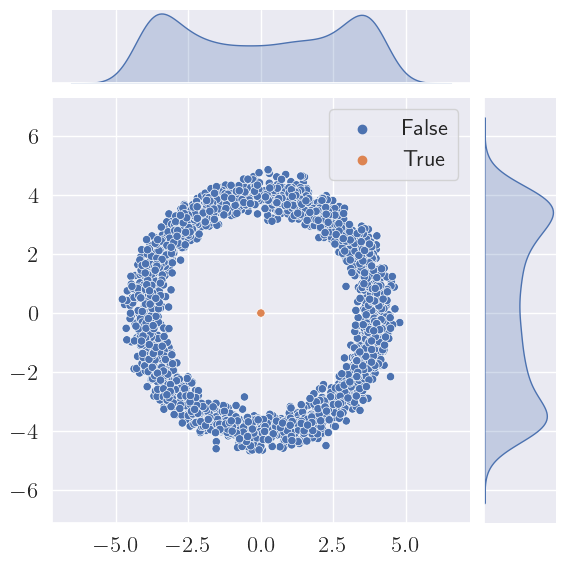

In [79]:
data, anomaly = generate_screening_dataset(2, 2560,1,np.random.randn, 2., 0.3)
sns.jointplot(x=data[:,0], y=data[:,1], hue=anomaly);

In [80]:
generate_screening = partial(generate_screening_dataset, N=2560, contamination=1, random_process=np.random.randn , radius=2., sigma=0.3)
results = pd.DataFrame(columns=["type", "auc", "d"])
counter = 0
for _ in range(100):
    _, result = run_experiment(5,generate_screening, 0)
    for d, row in result.iterrows():
        counter += 1
        results = pd.concat([results, pd.DataFrame({"type": f"IF", "auc": row["DepthBased"], "d": d}, index=[counter])])
        counter += 1
        results = pd.concat([results, pd.DataFrame({"type": f"PAC", "auc": row["AreaBased"], "d": d}, index=[counter])])

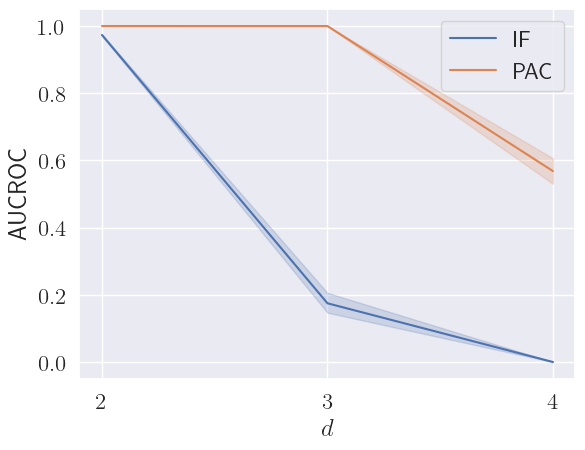

In [81]:
ax = sns.lineplot(results, x="d", y="auc", hue="type", markers=True);
ax.set(xlabel="$d$", ylabel=r"AUCROC", xticks=[2,3,4]);
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])


In [65]:
results.groupby(["d", "type"]).mean()

auc
d type          
2 IF    0.971504
  PAC   1.000000
3 IF    0.145526
  PAC   0.999918
4 IF    0.000000
  PAC   0.507100

## Motivating Example Distribution Based Aggregation Funtions (Sec II A)

In [114]:
def generate_dataset_outlier_along_one_axis(d, N, contamination, offset = 0.2, random_process = np.random.randn):
    outlier_count = round(contamination*N)
    inlier_count = N - outlier_count
    inliers = random_process((inlier_count, d))
    outliers = random_process((outlier_count, d))
    maxs = np.max(inliers, axis=0)
    mins = np.min(outliers, axis=0)
    shift = np.zeros(d)
    shift[0] = maxs[0] - mins[0]  + offset
    outliers += shift
    data = np.vstack([inliers, outliers])
    anomaly = np.array([i >= inlier_count for i in range(N)])
    return data, anomaly




In [161]:
rng = np.random.default_rng(0)
data, anomaly = generate_dataset_outlier_along_one_axis(d=5, N=128, contamination=0.01, offset=0.02,random_process=rng.random)
depth_based = partial(evaluate_clf, cls=DepthBasedRenyiIsolationForest, data=data, labels=~anomaly)
cls_0, score_0 = depth_based(alpha=0)
cls_0, score_inf = depth_based(alpha=np.inf)
scores = cls_0.get_scores_per_estimator(data)

In [162]:
df = pd.DataFrame(scores)
df.assign(anomaly=anomaly)
df_sorted = df.transpose().apply(axis=0, func=lambda x: np.sort(x)).transpose()
df_sorted.columns = [f"est{i}" for i in range(100)]
df_sorted = df_sorted.assign(anomaly=anomaly, idx=df_sorted.index)
df_long = pd.wide_to_long(df_sorted, stubnames="est", j="estimator", i=["anomaly", "idx"])

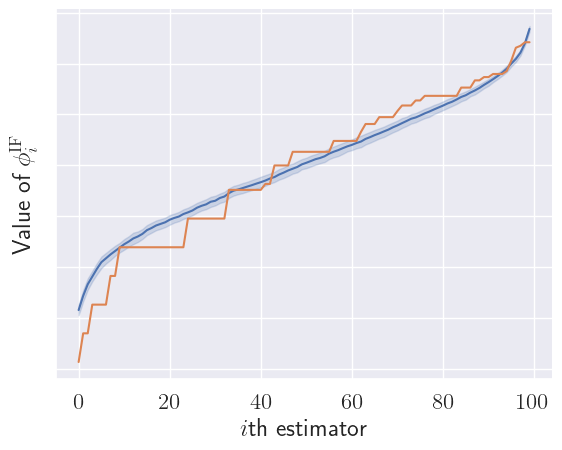

In [163]:
ax = sns.lineplot(df_long, x="estimator", y="est", hue="anomaly")
ax.set(xlabel="$i$th estimator", ylabel=r"Value of $\phi^\mathrm{IF}_i$")
ax.set_yticklabels([])
plt.legend([],[], frameon=False)
sns.despine()

In [ ]:
df_alphas = pd.DataFrame()
for alpha in np.arange(0,30,0.1):
    # we want the actual scores, not inverted for sklearn
    scores = -cls_0.score_samples(data, alpha=alpha)
    df_alphas[f"alpha{alpha}"] = scores

df_alphas = df_alphas.assign(anomaly=anomaly, idx=df_alphas.index)
df_alpha_long = pd.wide_to_long(df_alphas, stubnames="alpha", j="alph", i=["anomaly", "idx"], suffix="[+-]?([0-9]*[.])?[0-9]+")

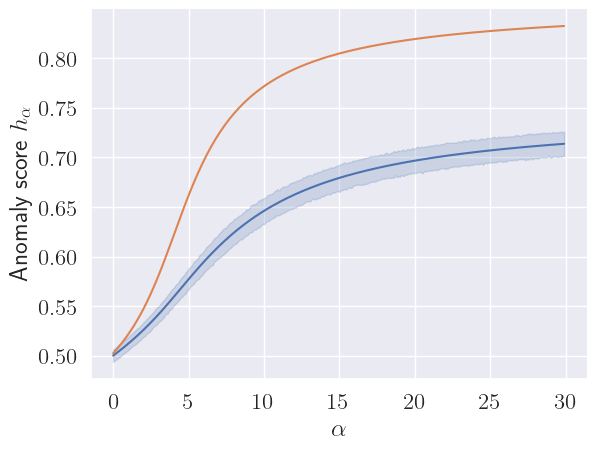

In [165]:
ax = sns.lineplot(df_alpha_long, x="alph", y="alpha", hue="anomaly")
ax.set(xlabel=r"$\alpha$", ylabel=r"Anomaly score $h_\alpha$")
plt.legend([],[], frameon=False)
sns.despine()


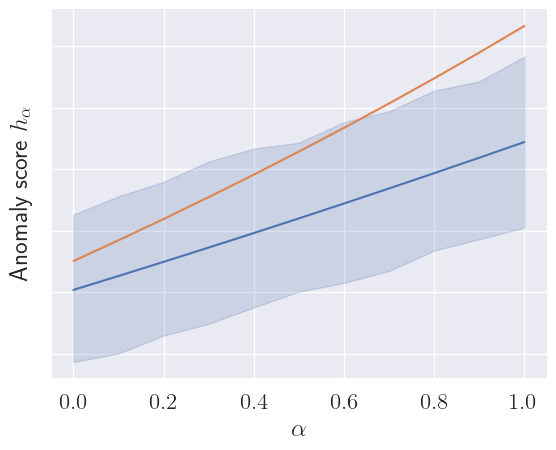

In [166]:
ax = sns.lineplot(df_alpha_long[df_alpha_long.reset_index()["alph"].values <= 1], x="alph", y="alpha", hue="anomaly")
ax.set(xlabel=r"$\alpha$", ylabel=r"Anomaly score $h_\alpha$")
ax.set_yticklabels([])
plt.legend([],[], frameon=False)
sns.despine()

In [121]:
data_fig, anomaly_fig = generate_dataset_outlier_along_one_axis(d=2, N=128, contamination=0.005, offset=0.05,random_process=rng.random)

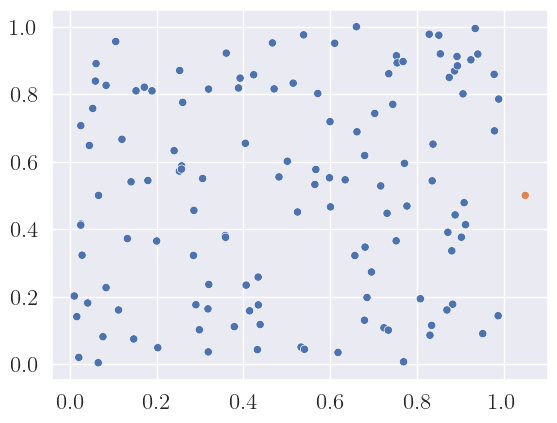

In [827]:
sns.scatterplot(x=data_fig[:,0], y=data_fig[:,1], hue=anomaly)
plt.legend([],[], frameon=False)

### Run several times for statistics

In [833]:
scores_0 = []
scores_inf = []
for i in range(100):
    data, anomaly = generate_dataset_outlier_along_one_axis(d=10, N=128, contamination=0.01, offset=0.05,random_process=rng.random)
    depth_based = partial(evaluate_clf, cls=DepthBasedRenyiIsolationForest, data=data, labels=~anomaly)
    cls_0, score_0 = depth_based(alpha=0)
    cls_0, score_inf = depth_based(alpha=np.inf)
    scores_0.append(score_0)
    scores_inf.append(score_inf)
print("Average aucroc IF (alpha=0):", np.mean(scores_0), "Average aucroc alpha=inf", np.mean(scores_inf))

Average aucroc IF (alpha=0): 0.7994488188976377 Average aucroc alpha=inf 0.9891732283464569
